In [1]:
# %reset 

# OOM 계속 뜬다
# 왜 ?
# 다른 파일에서 학습 돌리고 있었다
# 학습 끝났는데도 그러네

In [1]:
# 필요한 라이브러리들 불러오고 버전 확인해보자

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import PIL
import cv2
import keras_ocr

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(cv2.__version__)
print(keras_ocr.__version__)

2.6.0
1.21.4
8.3.2
4.5.3
0.8.8


In [2]:
from keras_ocr.detection import Detector

HOME_DIR = '/aiffel/aiffel/ocr'

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

# 자동으로 ocr pretrained 모델을 찾고 없으면 저장한다. 
# Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
# Downloading /aiffel/.keras-ocr/craft_mlt_25k.h5

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


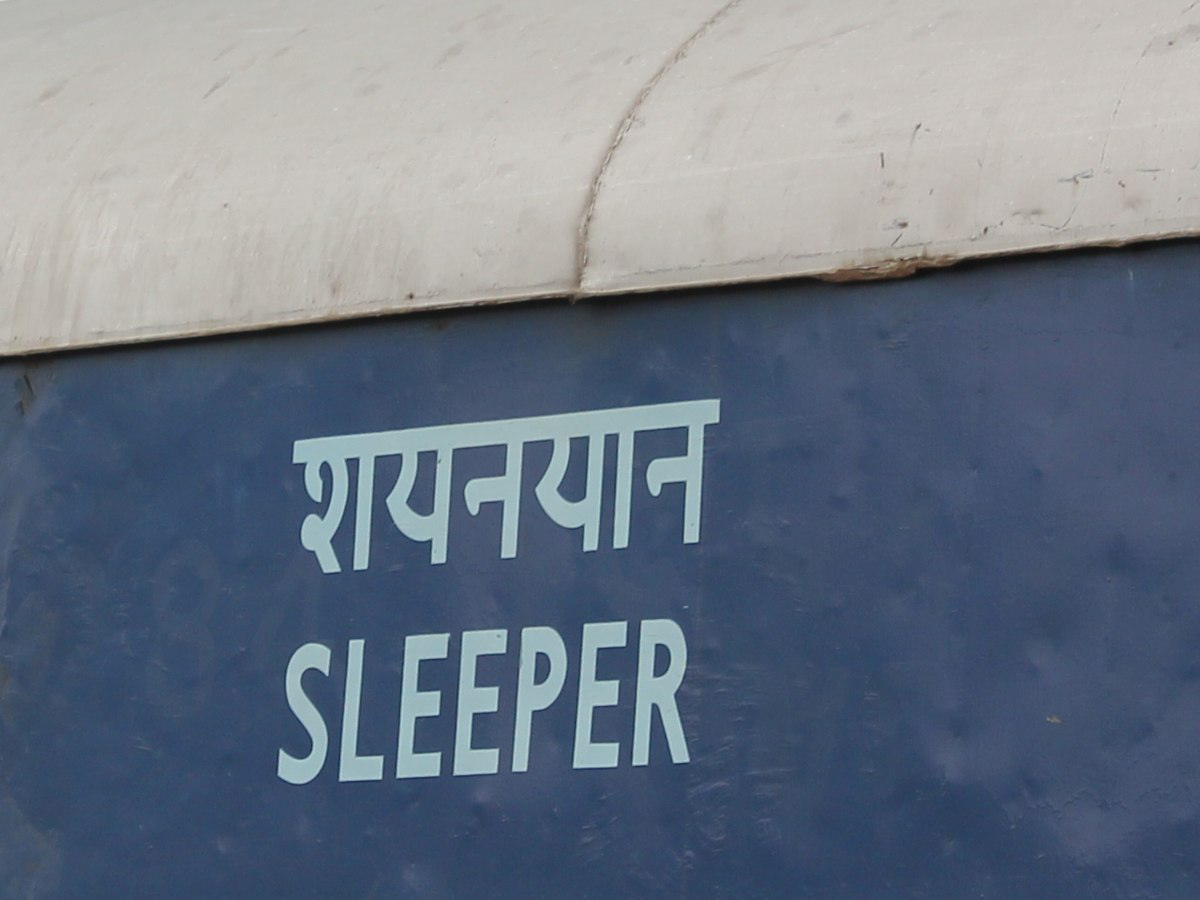

In [3]:
# /aiffel/aiffel/ocr/data/sample.jpg
keras.utils.load_img(SAMPLE_IMG_PATH)

In [4]:
# input : 이미지 경로
# how : keras-ocr Detector를 이용
# output : 이미지 내의 문자가 있는 위치

import keras_ocr
import numpy as np
from PIL import Image, ImageDraw

def detect_text(img_path):
    # Load the image
    img_pil = Image.open(img_path)
    img_array = np.array(img_pil)

    # Preprocess the image for OCR
    # This might include resizing, adding batch dimension, etc., as required by the model
    img_for_ocr = np.expand_dims(img_array, axis=0)  # Adding batch dimension

    # Perform OCR to get text detections
    ocr_result = detector.detect(img_for_ocr)[0]  # Assuming batch size of 1

    # Create an image draw object to visualize the detections
    img_draw = ImageDraw.Draw(img_pil)

    cropped_imgs = []
    for text_result in ocr_result:
        
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))

    return img_pil, cropped_imgs

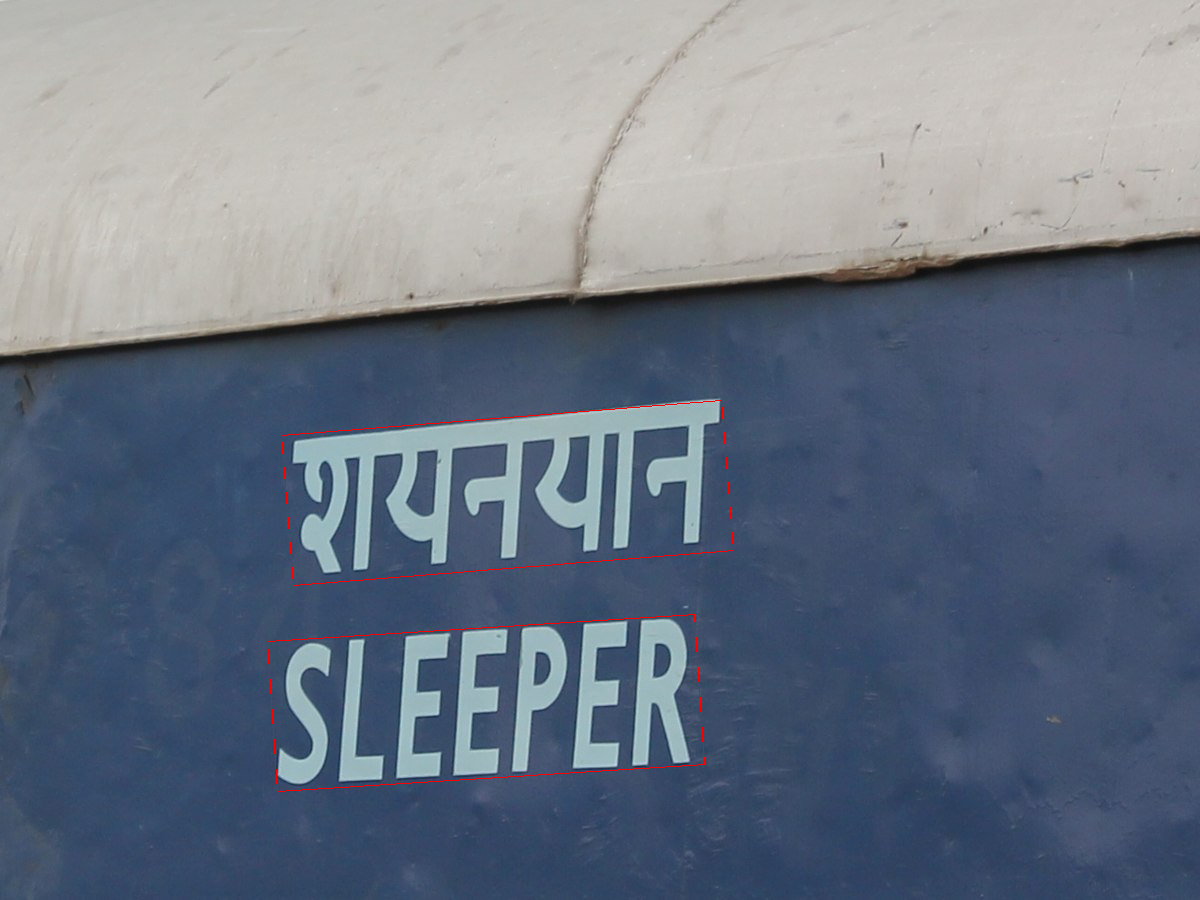

In [5]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

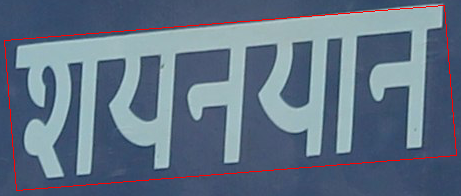

In [6]:
cropped_img[0]

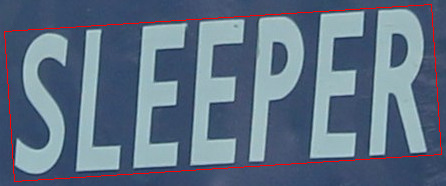

In [7]:
cropped_img[1]

In [8]:
# recognition model 불러오기

# 직접 정의한 코드들 , OCR_project_(1)
import os
from asset import ctc_lambda_func, build_crnn_model

HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'
checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5'

model = build_crnn_model()
model.load_weights(checkpoint_path)

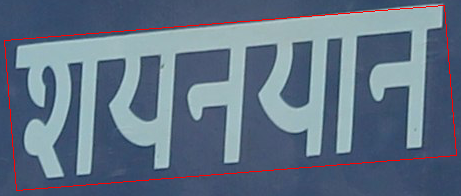

In [12]:
cropped_img[0]

In [13]:
model.predict(np.array(cropped_img[0]))

ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:199 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer model_2 expects 4 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 461, 3) dtype=uint8>]


In [ ]:
def recognize_img(pil_img, input_img_size=(100,32)):
    # TODO: 잘려진 단어 이미지를 인식하는 코드를 작성하세요!
    

# 회고
---

확실히 모르는 개념을 계속 배우다보니 컨셉을 이해하는 속도가 빨라진 것 같다.   
OCR을 한 문장으로 정의하면 다음과 같겠다.  
"OCR은 문자가 어딨는지 먼저 찾고, 그 다음에 무슨 문자인지 찾는 문제."
  
Segementation에 이어서 데이터 처리하는 class를 정의해서 사용했다.  
keras의 sequence class를 상속 받아서 짜는 건데, 확실히 tf.data.Dataset 객체를 이용하는 것보다 다루기가 편해 좋은 것 같다.  
익혀둘 필요가 있을 것 같다.  
  
위치를 찾는 건 keras_ocr의 detector class를 사용했는데, 정확히 이해하고 쓴 건 아니라 좀 그렇다.  
무슨 모델인지 한번 찾아봐야겠다.  
   
찾은 위치를 가지고 무슨 글자인지 확인하는건 CRNN 모델을 사용했다.   
피처맵에서는 순서정보다 남아있고, 레이블도 순서가 있기에 피처맵을 RNN으로 조합해 예측하는게 효과적이라고 한다.  
CNN과 RNN을 함께 조합해 사용한 모델은 처음이라 재밌었다.  